In [ ]:
!pip install ranx

In [1]:
!wget -O trec-pm.tar.xz https://th-koeln.sciebo.de/s/JTTV4fxFmuCGMeY/download
!tar -xf trec-pm.tar.xz

--2022-12-20 12:25:12--  https://th-koeln.sciebo.de/s/JTTV4fxFmuCGMeY/download
Auflösen des Hostnamens th-koeln.sciebo.de (th-koeln.sciebo.de)… 128.176.1.2
Verbindungsaufbau zu th-koeln.sciebo.de (th-koeln.sciebo.de)|128.176.1.2|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 224988232 (215M) [application/octet-stream]
Wird in »trec-pm.tar.xz« gespeichert.

trec-pm.tar.xz      100%[===================>] 214,57M  5,36MB/s    in 51s     

2022-12-20 12:26:04 (4,21 MB/s) - »trec-pm.tar.xz« gespeichert [224988232/224988232]



In [2]:
!wget -O bibliometric.tar.xz https://th-koeln.sciebo.de/s/BRolGxMzrCipoTT/download
!tar -xf bibliometric.tar.xz

--2022-12-20 12:26:10--  https://th-koeln.sciebo.de/s/BRolGxMzrCipoTT/download
Auflösen des Hostnamens th-koeln.sciebo.de (th-koeln.sciebo.de)… 128.176.1.2
Verbindungsaufbau zu th-koeln.sciebo.de (th-koeln.sciebo.de)|128.176.1.2|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 2054660 (2,0M) [application/octet-stream]
Wird in »bibliometric.tar.xz« gespeichert.

bibliometric.tar.xz 100%[===================>]   1,96M  3,56MB/s    in 0,6s    

2022-12-20 12:26:11 (3,56 MB/s) - »bibliometric.tar.xz« gespeichert [2054660/2054660]



In [3]:
import os
import random
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')
from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion
from random import randint

In [4]:
years_and_qrels = { 
    '2017': {
        'DIR_IN': 'trec-pm/trec-pm-2017-abstracts', 
        'DIR_RUN': 'runs/trec-pm-2017-abstracts',    
        'PATH_QRELS': "trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt",
        'DIR_CSV': 'experimental_results/trec-pm-2017-abstracts/',
        'YEAR': 2017
    }, 
    '2018': {
        'DIR_IN': 'trec-pm/trec-pm-2018-abstracts', 
        'DIR_RUN': 'runs/trec-pm-2018-abstracts',
        'PATH_QRELS': "trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt",
        'DIR_CSV': 'experimental_results/trec-pm-2018-abstracts/',
        'YEAR': 2018
    },
    '2019': {
        'DIR_IN': 'trec-pm/trec-pm-2019-abstracts', 
        'DIR_RUN': 'runs/trec-pm-2019-abstracts',
        'PATH_QRELS': "trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt",
        'DIR_CSV': 'experimental_results/trec-pm-2019-abstracts/',
        'YEAR': 2019
    }
}

In [5]:
def extract_runs(year_and_qrels):
    os.makedirs(year_and_qrels['DIR_RUN'], exist_ok=True)

    for root, dirs, files in os.walk(year_and_qrels['DIR_IN']):
        for file in files:
            if file.endswith(".gz"):
                run_name = file.split('.')[1]
                with gzip.open(os.path.join(root, file), 'rb') as f_in:
                    file_content = f_in.read()
                    file_out = year_and_qrels['DIR_RUN'] + '/' + run_name
                    with open(file_out, 'wb') as f_out:
                        f_out.write(file_content) 
                        if year_and_qrels['YEAR'] == 2019:
                            !cat $file_out | cut -d" " -f1 > tmp; mv tmp $file_out
                            
for year in years_and_qrels:
    extract_runs(years_and_qrels[year])

In [6]:
def get_run(category, year=2017):
    
    run_names = {'TC': 'Citations (C)',
                 'ATTENTION_SCORE': 'Altmetrics (A)',
                 'RL': 'Research level (R)',
                 'IF': 'Impact factor (I)',
                 'PY': 'Publication year (P)'}
    
    
    df = pd.read_csv('STI_Ergebnisse_final.txt', sep='\t', low_memory=False)
    _run = Run(name=run_names[category])
    
    _df = df[df[category].notna()]
    _df = _df[_df['TOPIC'].str.contains(str(year), regex=False)]
    _df = _df[['TOPIC','PUBMED_ID', category]]
    
    if category in ['IF', 'RL']:
        _df[category] = _df[category].str.replace(',','.').astype(float)

    for row in _df.iterrows():
        topic = row[1]['TOPIC'].split('-')[1]
        pubmed_id = row[1]['PUBMED_ID']
        cnt = row[1][category]

        if cnt > 0:
            _run.add_score(str(topic), str(pubmed_id), float(cnt))
    
    return _run

def get_random_run(qrels):
    _run = Run(name='random')
    
    for topic, _qrels in dict(qrels).items():
        for pubmed_id, label in _qrels.items():
            _run.add_score(str(topic), str(pubmed_id), randint(1,10000))
    
    return _run

## RQ1: To what extent can bibliometric relevance signals be used as ranking criteria for TREC Precision Medicine?

In [7]:
current_year = '2017'

In [8]:
qrels = Qrels.from_file(years_and_qrels[current_year]['PATH_QRELS'], kind="trec")

run_cite = get_run('TC', year=years_and_qrels[current_year]['YEAR']) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=years_and_qrels[current_year]['YEAR']) # get run based on attention score
run_py = get_run('PY', year=years_and_qrels[current_year]['YEAR']) 
run_rl = get_run('RL', year=years_and_qrels[current_year]['YEAR']) 
run_if = get_run('IF', year=years_and_qrels[current_year]['YEAR']) 

report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if],
    metrics=["recall", "ndcg", "map", "precision@10", "bpref"],
    rounding_digits=4,
    max_p=0.05
)

print(report)
print(report.to_latex())

#    Model                 Recall      NDCG       MAP        P@10     BPref
---  --------------------  ----------  ---------  ---------  -------  -------
a    Citations (C)         0.7853ᵇᵈᵉ   0.4992ᵇᵈᵉ  0.1812ᵇᵈᵉ  0.2700ᵈ  0.1577ᵈ
b    Altmetrics (A)        0.4162      0.3163     0.1020     0.2400ᵈ  0.1434
c    Publication year (P)  0.7972ᵃᵇᵈᵉ  0.5069ᵇᵈᵉ  0.1733ᵇᵈᵉ  0.2033ᵈ  0.1541ᵈ
d    Research level (R)    0.7608ᵇᵉ    0.4666ᵇᵉ   0.1546ᵇᵉ   0.1200   0.1307
e    Impact factor (I)     0.6301ᵇ     0.4162ᵇ    0.1399ᵇ    0.2500ᵈ  0.1444
% Add in preamble
\usepackage{graphicx}
\usepackage{booktabs}


% To change the table size, act on the resizebox argument `0.8`.
\begin{table*}[ht]
\centering
\caption{
Overall effectiveness of the models.
The best results are highlighted in boldface.
Superscripts denote significant differences in paired Student's t-test with $p \le 0.05$.
}
\resizebox{0.8\textwidth}{!}{
\begin{tabular}{c|l|c|c|c|c|c}
\toprule
\textbf{\#}
& \textbf{Model}
& \textbf{Recall

Random ranking based on qrels

In [9]:
_df_data = []
cnt = 0
trials = 10
while cnt < trials:
    run_random = get_random_run(qrels) 
    _df_data.append(evaluate(qrels, run_random,["recall", "ndcg", "map", "precision@10", "bpref"]))
    cnt += 1
df = pd.DataFrame(_df_data)
print(df.mean().to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
recall       &  1.000000 \\
ndcg         &  0.578100 \\
map          &  0.179823 \\
precision@10 &  0.172000 \\
bpref        &  0.117979 \\
\bottomrule
\end{tabular}



/var/folders/6r/m6x_qnvj5cs5fyw9sw9xczfw0000gn/T/ipykernel_86835/230924698.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.mean().to_latex())


### RBP comparison

In [10]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if],
    metrics=["rbp.95", "rbp.9", "rbp.85", "rbp.8", "rbp.75"],
    rounding_digits=4,
    max_p=0.05 
)

print(report)
# print(report.to_latex())

#    Model                 RBP.95    RBP.9    RBP.85    RBP.8    RBP.75
---  --------------------  --------  -------  --------  -------  --------
a    Citations (C)         0.2507ᵈ   0.2595ᵈ  0.2611ᵈ   0.2603ᵈ  0.2593ᵈ
b    Altmetrics (A)        0.2369ᵈ   0.2388ᵈ  0.2367ᵈ   0.2331ᵈ  0.2291ᵈ
c    Publication year (P)  0.2144ᵈ   0.2128ᵈ  0.2113ᵈ   0.2114ᵈ  0.2130
d    Research level (R)    0.1542    0.1410   0.1336    0.1292   0.1265
e    Impact factor (I)     0.2272ᵈ   0.2355ᵈ  0.2389ᵈ   0.2397ᵈ  0.2390ᵈ


### nDCG comparison

In [11]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if],
    metrics=["ndcg@1", "ndcg@5", "ndcg@10", "ndcg@100", "ndcg@1000"],
    rounding_digits=4,
    max_p=0.05  
)

print(report)
# print(report.to_latex())

#    Model                 NDCG@1    NDCG@5    NDCG@10    NDCG@100    NDCG@1000
---  --------------------  --------  --------  ---------  ----------  -----------
a    Citations (C)         0.1333    0.1759ᵈ   0.1969ᵈ    0.2225ᵈ     0.4992ᵇᵈᵉ
b    Altmetrics (A)        0.1833    0.1978ᵈ   0.1935ᵈ    0.2317ᵈᵉ    0.3163
c    Publication year (P)  0.2333ᵈ   0.1811ᵈ   0.1745ᵈ    0.2224ᵈ     0.5069ᵇᵈᵉ
d    Research level (R)    0.0500    0.0845    0.0839     0.1612      0.4666ᵇᵉ
e    Impact factor (I)     0.1833ᵈ   0.1811ᵈ   0.1864ᵈ    0.2076ᵈ     0.4162ᵇ


### Different rank fusions of bibliometric data.

In [13]:
fuse_method = 'rrf'

fused_runs = []

run_dict = {'C': run_cite,
            'A': run_alt,
            'P': run_py,
            'R': run_rl,
            'I': run_if}

# https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements
import itertools

# run_codes = ['a', 'b', 'c', 'd', 'e']
run_codes = list(run_dict.keys())

for L in range(len(run_codes) + 1):
    for subset in itertools.combinations(run_codes, L):
        if len(subset) > 1:
            
            run_name = ''.join(list(subset))
            comb = [run_dict.get(code) for code in subset]
            run_fuse = fuse(runs=comb, method=fuse_method)
            run_fuse.name = run_name
            fused_runs.append(run_fuse)
                 
# runs = [run_cite, run_alt, run_rl, run_if, run_py, run_random] + fused_runs
  
report = compare(
    qrels=qrels,
    runs=fused_runs,
    metrics=["ndcg", "map", "precision@10", "bpref"],
    rounding_digits=4,
    max_p=0.05 
)

print(report)
print(report.to_latex())

#    Model    NDCG                          MAP                         P@10              BPref
---  -------  ----------------------------  --------------------------  ----------------  ---------------------------
a    CA       0.5256ᶜᵈᶠᵍʰʲⁿᵖˢᵗˣ             0.1917ᶜᵈᶠᵍʰʲᵖˢᵗʷˣ           0.2700            0.1674ᶜᵈᶠʲˡᵐᵖʷ
b    CP       0.5217ᶜᵈᶠᵍʰʲⁿᵖᵗˣ              0.1919ᶜᵈᶠᵍʰᶦʲⁿᵖˢᵗˣʸ         0.2733            0.1695ᶜᵈᶠʰᶦʲⁿᵖˢᵗˣ
c    CR       0.4967ʲ                       0.1721ʲ                     0.2067            0.1459ʲ
d    CI       0.5034ʲ                       0.1784ʲ                     0.2767            0.1538ʲ
e    AP       0.5299ᶜᵈᶠᵍʰᶦʲⁿᵖˢᵗˣ            0.1880ᶠᵍʰᶦʲᵗ                0.2533ʲ           0.1698ᶜᶠʰᶦʲⁿᵖ۹ᵗ
f    AR       0.5061ᵍʲ                      0.1743ʲ                     0.2267            0.1513ʲ
g    AI       0.4872                        0.1712                      0.2967ᶜʲˢᵗ        0.1589ʲ
h    PR       0.4978ʲ                       0.1677                      0.2

## RQ2: Can bibliometric-enhanced rank fusion methods improve the overall retrieval performance?

In [15]:
fuse_method = "rrf"

df_data = []

for root, dirs, files in os.walk(years_and_qrels[current_year]['DIR_RUN']):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_rrf = fuse(runs=[run, run_cite, run_alt, run_py], method=fuse_method)

        report = compare(
            qrels=qrels,
            runs=[run, run_rrf],
            metrics=["ndcg", "map", "precision@10", "bpref", 
                     "ndcg@10", "ndcg@50", "ndcg@100", "ndcg@200", "ndcg@500", "ndcg@1000"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_method).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_method)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(years_and_qrels[current_year]['DIR_CSV'], exist_ok=True)
file_out = years_and_qrels[current_year]['DIR_CSV'] + fuse_method + '.csv'
df.to_csv(file_out)

### nDCG analysis

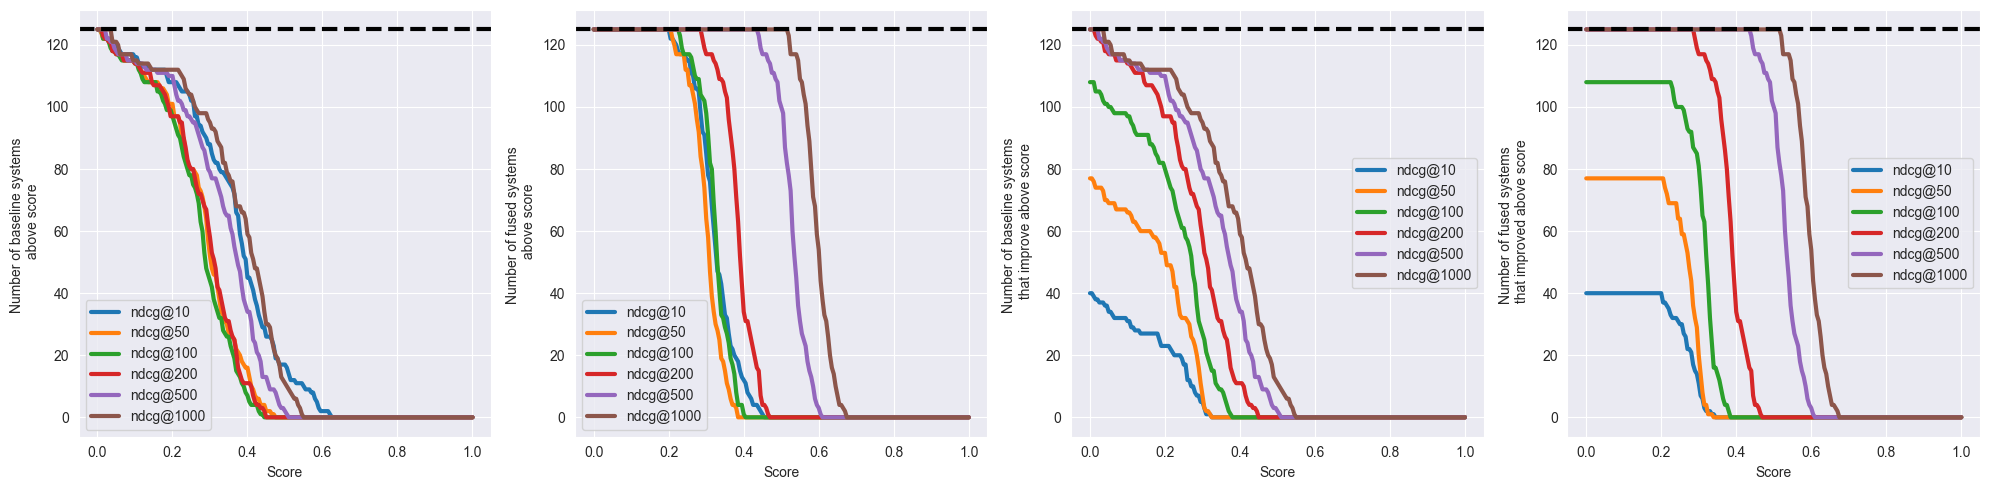

In [16]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (base)'] > thresh)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of baseline systems \n above score', ax=axes[0])
axes[0].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in ['ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (fuse)'] > thresh)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of fused systems \n above score', ax=axes[1])
axes[1].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (base)'] > thresh) & (df[measure +' (diff)'] > 0)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of baseline systems \n that improve above score', ax=axes[2])
axes[2].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (fuse)'] > thresh) & (df[measure +' (diff)'] > 0)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of fused systems \n that improved above score', ax=axes[3])
axes[3].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

plt.tight_layout()
plt.savefig('figures/trec-pm-2017-abstracts/ndcg.rrf.pdf', bbox_inches='tight')

# TREC PM 2017 - Abstracts

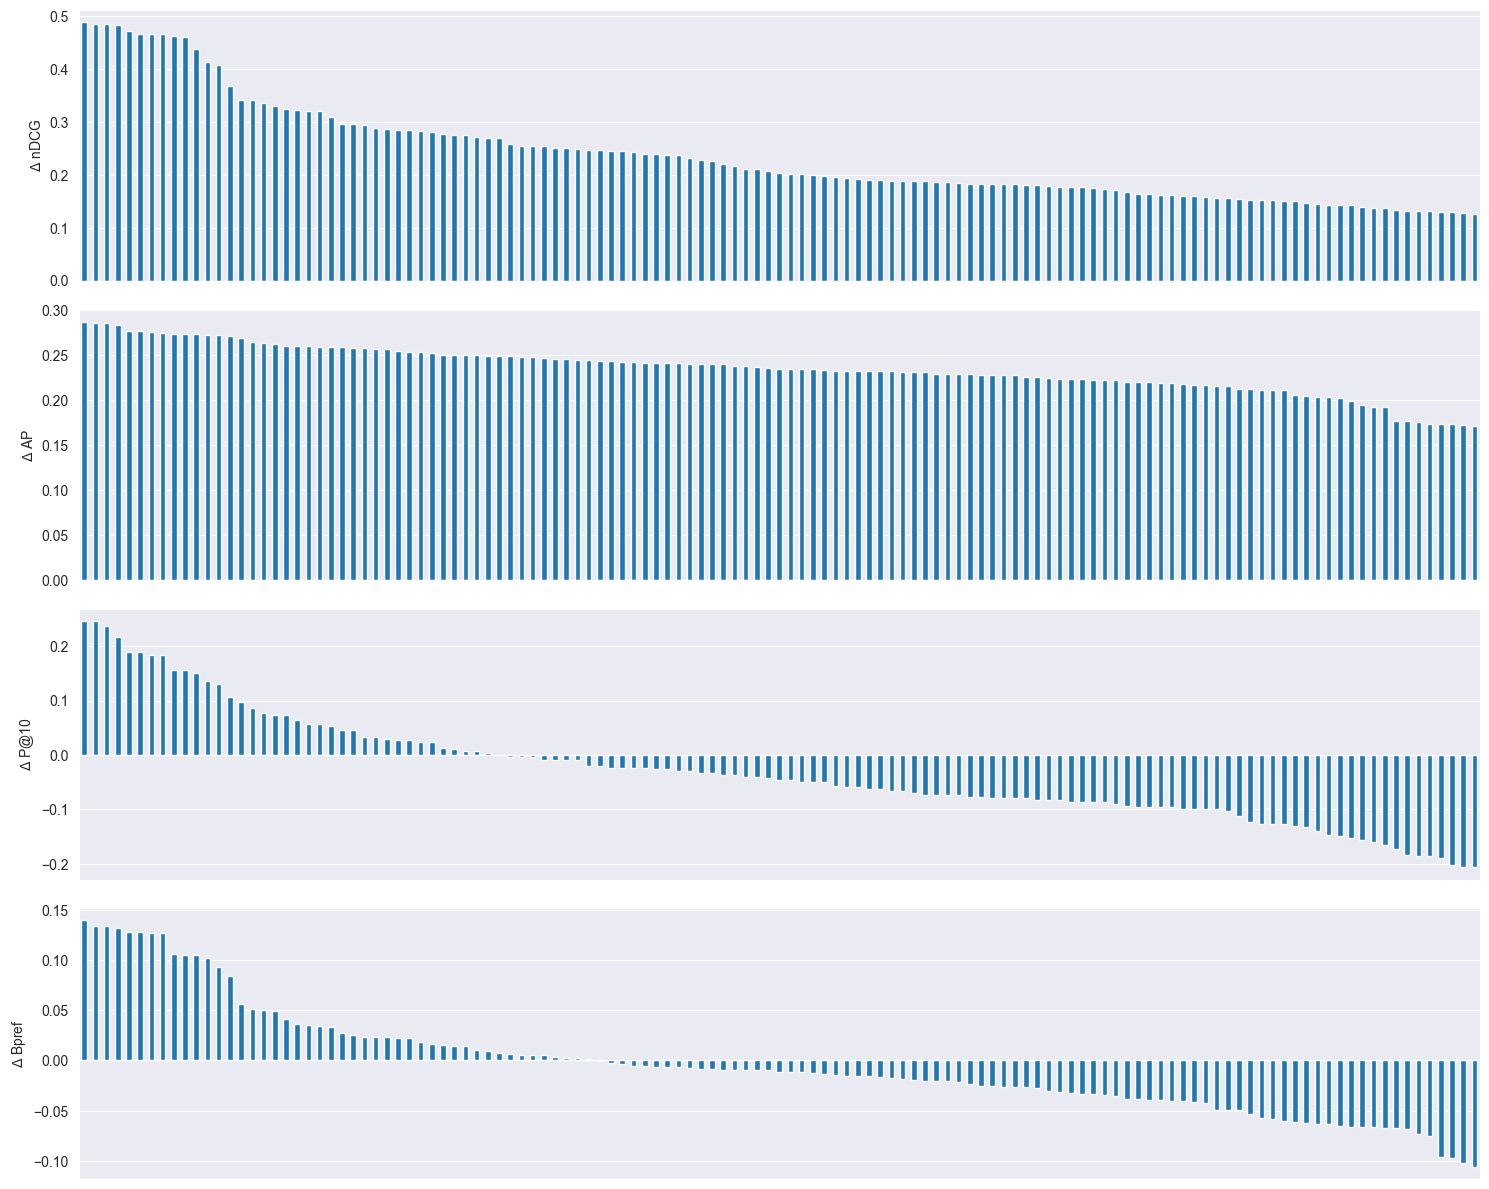

In [30]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[1]).get_xaxis().set_visible(False)
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[0]).get_xaxis().set_visible(False)
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2]).get_xaxis().set_visible(False)
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3]).get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig('figures/trec-pm-2017-abstracts/delta.rrf.pdf', bbox_inches='tight')

# TREC PM 2018 - Abstracts

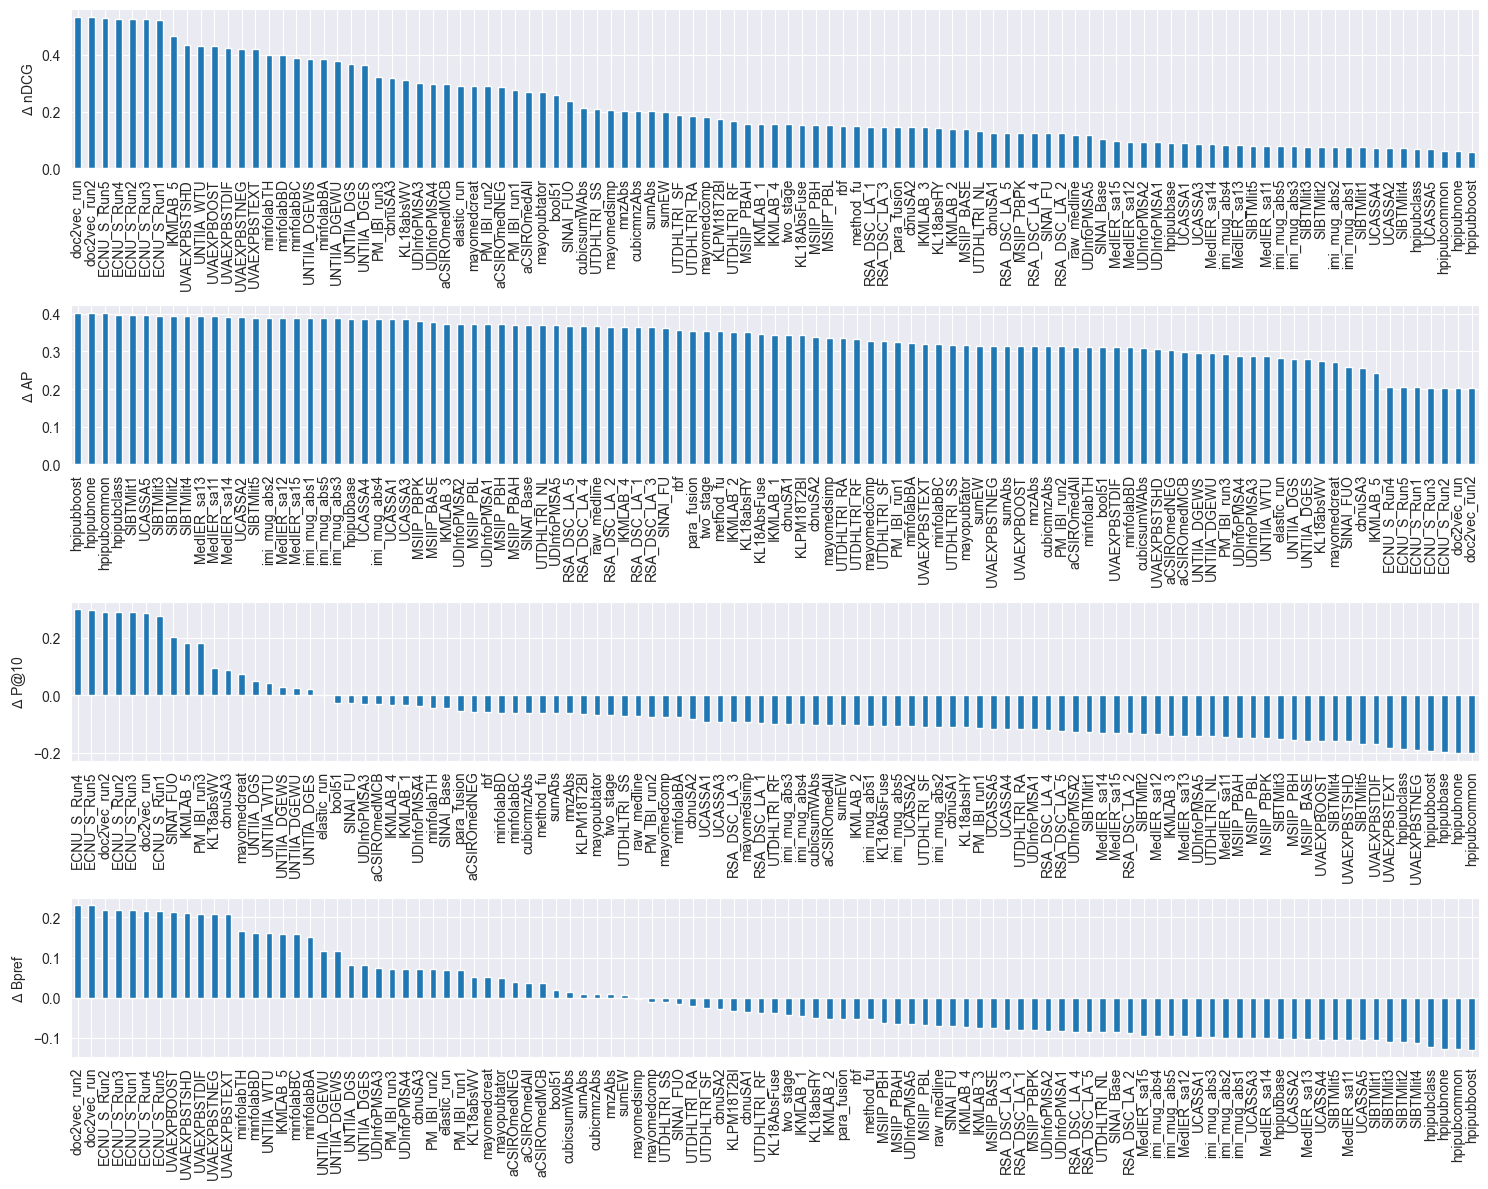

In [31]:
df = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[1]).get_xaxis().set_visible(False)
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[0]).get_xaxis().set_visible(False)
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2]).get_xaxis().set_visible(False)
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3]).get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig('figures/trec-pm-2018-abstracts/delta.rrf.pdf',bbox_inches='tight')

# TREC PM 2019 - Abstracts

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[1]).get_xaxis().set_visible(False)
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[0]).get_xaxis().set_visible(False)
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2]).get_xaxis().set_visible(False)
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3]).get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig('figures/trec-pm-2019-abstracts/delta.rrf.pdf',bbox_inches='tight')

# TREC PM all years - Abstracts

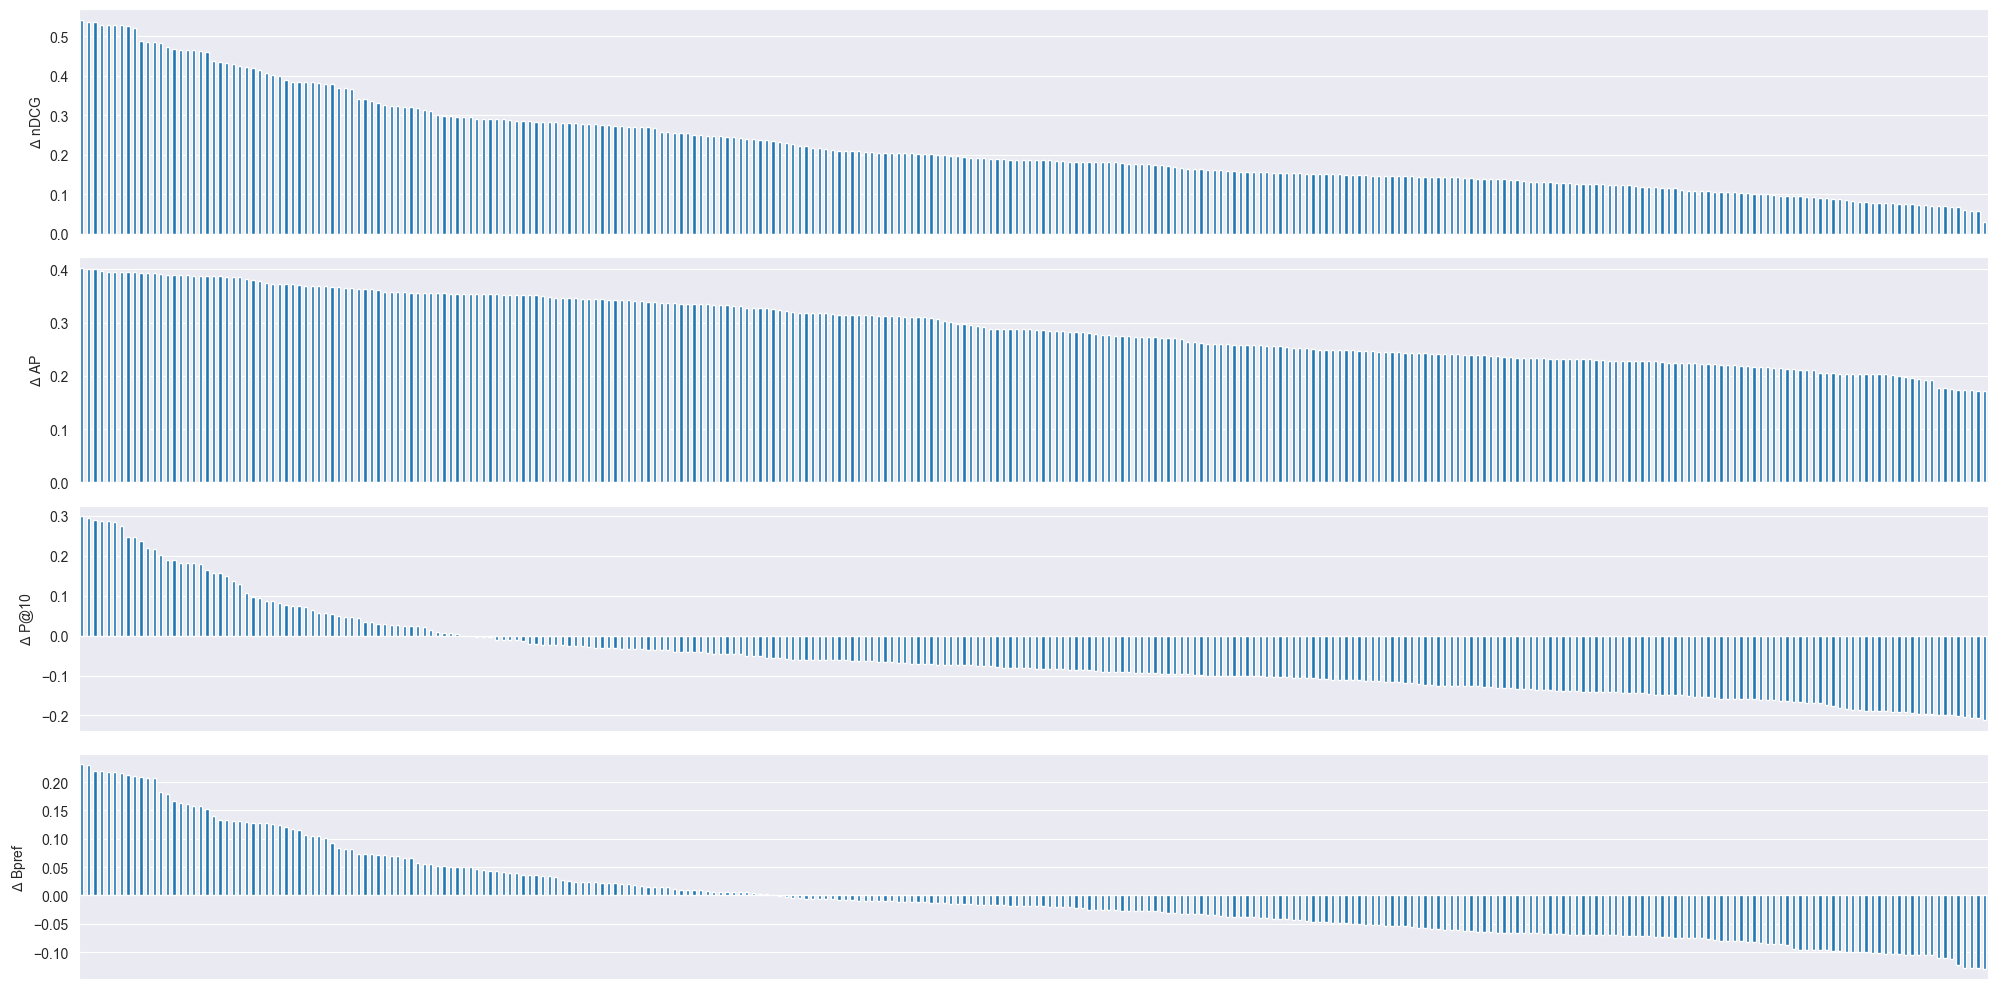

In [40]:
df = pd.concat ( map (pd.read_csv, ['experimental_results/trec-pm-2017-abstracts/rrf.csv', 'experimental_results/trec-pm-2018-abstracts/rrf.csv', 'experimental_results/trec-pm-2019-abstracts/rrf.csv']),ignore_index=True)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[1]).get_xaxis().set_visible(False)
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[0]).get_xaxis().set_visible(False)
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2]).get_xaxis().set_visible(False)
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3]).get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig('figures/all_years_delta.rrf.pdf', bbox_inches='tight')

# Optimized Fusion Methods

see also: https://amenra.github.io/ranx/fusion/

In [39]:
### selection ###

fuse_method = fuse_dict_key ="rbc"
# fuse_method = fuse_dict_key ="bayesfuse"
# fuse_method = fuse_dict_key ="probfuse"

#### score-based methods ####

# fuse_method = "anz"; fuse_dict_key = "comb_anz"
# fuse_method = "max"; fuse_dict_key = "comb_max"
# fuse_method = "med"; fuse_dict_key = "comb_med"
# fuse_method = "min"; fuse_dict_key = "comb_min"
# fuse_method = "mnz"; fuse_dict_key = "comb_mnz"
# fuse_method = "sum"; fuse_dict_key = "comb_sum"
# fuse_method = "gmnz"; fuse_dict_key = "comb_gmnz"
# fuse_method = "mixed"; fuse_dict_key = "comb_mixed"
# fuse_method = "wmnz"; fuse_dict_key = "wmnz"
# fuse_method = "wsum"; fuse_dict_key = "wsum"

#### rank-based methods ####

# fuse_method = fuse_dict_key = "isr"
# fuse_method = fuse_dict_key = "log_isr"
# fuse_method = fuse_dict_key = "logn_isr"
# fuse_method = fuse_dict_key = "rbc"
# fuse_method = fuse_dict_key = "rrf"

#### probabilistic methods ####

# fuse_method = fuse_dict_key = "bayesfuse"
# fuse_method = fuse_dict_key = "mapfuse"
# fuse_method = fuse_dict_key = "posfuse"
# fuse_method = fuse_dict_key = "probfuse"
# fuse_method = fuse_dict_key = "segfuse"
# fuse_method = fuse_dict_key = "slidefuse"

#### voting-based methods ####

# fuse_method = fuse_dict_key = "bordafuse"
# fuse_method = fuse_dict_key = "w_bordafuse"
# fuse_method = fuse_dict_key = "condorcet"
# fuse_method = fuse_dict_key = "w_condorcet"

skip_list = ["bordafuse", "condorcet", "mnz", "sum", "min", "anz", "med", "max", "isr", "log_isr"]

if years_and_qrels[current_year]['YEAR'] == 2017:
    samples = 5
    dir_train = 'runs/trec-pm-2018-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt', kind="trec")
    
if years_and_qrels[current_year]['YEAR'] == 2018:
    samples = 5
    dir_train = 'runs/trec-pm-2019-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt', kind="trec")

if years_and_qrels[current_year]['YEAR'] == 2019:
    samples = 5
    dir_train = 'runs/trec-pm-2017-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt', kind="trec")

if fuse_method not in skip_list:

    best_params = optimize_fusion(
        qrels=train_qrels,
        runs=train_runs,
        norm="min-max",
        method=fuse_method,
        metric="ndcg@100"
    )

run_cite = get_run('TC', year=years_and_qrels[current_year]['YEAR']) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=years_and_qrels[current_year]['YEAR']) # get run based on attention score
run_py = get_run('PY', year=years_and_qrels[current_year]['YEAR']) # get run based on publication year
qrels = Qrels.from_file(years_and_qrels[current_year]['PATH_QRELS'], kind="trec")

df_data = []

for root, dirs, files in os.walk(years_and_qrels[current_year]['DIR_RUN']):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        if fuse_method in skip_list:
            run_fuse = fuse(
                runs=[run, run_cite, run_alt, run_py],       
                method=fuse_method     
            )
            
        else:
            
            run_fuse = fuse(
                runs=[run, run_cite, run_alt, run_py],  
                norm="min-max",       
                method=fuse_method,        
                params=best_params,
            )

        report = compare(
            qrels=qrels,
            runs=[run, run_fuse],
            metrics=["ndcg", "map", "precision@10", "bpref"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_dict_key).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_dict_key)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(years_and_qrels[current_year]['DIR_CSV'], exist_ok=True)
file_out = years_and_qrels[current_year]['DIR_CSV'] + fuse_method + '.csv'
df.to_csv(file_out)

/Users/christin/miniconda3/lib/python3.9/site-packages/rich/live.py:229: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

## General statistics about how rank fusion changes the retrieval performance

In [ ]:
def general_stats(method):
    data = {}
    for year in [2017, 2018, 2019]:
        
        path = 'experimental_results/trec-pm-' + str(year) + '-abstracts/' + method + '.csv'
        df = pd.read_csv(path)
        _data = {
            'Number of systems': len(df),
            'Improvements (nDCG)': int(len(df[df['ndcg (diff)'] > 0])),
            'Signif. improvements (nDCG)': len(df[(df['ndcg (pval)'] < 0.05) & (df['ndcg (diff)'] > 0)]),
            'Average improvement (nDCG)': df[(df['ndcg (pval)'] < 0.05) & (df['ndcg (diff)'] > 0)]['ndcg (diff)'].mean(),
            'Overall change (nDCG)': df['ndcg (diff)'].mean(),
            'Improvements (AP)': len(df[df['map (diff)'] > 0]),
            'Signif. improvements (AP)': len(df[(df['map (pval)'] < 0.05) & (df['map (diff)'] > 0)]),
            'Average improvement (AP)': df[(df['map (pval)'] < 0.05) & (df['map (diff)'] > 0)]['map (diff)'].mean(),
            'Overall change (AP)': df['map (diff)'].mean(),
            'Improvements (P@10)': len(df[df['precision@10 (diff)'] > 0]),
            'Signif. improvements (P@10)': len(df[(df['precision@10 (pval)'] < 0.05) & (df['precision@10 (diff)'] > 0)]),
            'Average improvement (P@10)': df[(df['precision@10 (pval)'] < 0.05) & (df['precision@10 (diff)'] > 0)]['precision@10 (diff)'].mean(),
            'Overall change (P@10)': df['precision@10 (diff)'].mean(),
            'Improvements (Bpref)': len(df[df['bpref (diff)'] > 0]),
            'Signif. improvements (Bpref)': len(df[(df['bpref (pval)'] < 0.05) & (df['bpref (diff)'] > 0)]),
            'Average improvement (Bpref)': df[(df['bpref (pval)'] < 0.05) & (df['bpref (diff)'] > 0)]['bpref (diff)'].mean(),
            'Overall change (Bpref)': df['bpref (diff)'].mean()
        }
        data[year] = _data

    return pd.DataFrame.from_dict(data).reindex(_data.keys())

RRF

In [ ]:
general_stats('rrf')

RBC

In [ ]:
general_stats('rbc')

BayesFuse

In [ ]:
general_stats('bayesfuse')

ProbFuse

In [ ]:
general_stats('probfuse')

In [ ]:
df = general_stats('rrf')
df = pd.concat([df, general_stats('rbc').reindex(df.index)], axis=1)
df = pd.concat([df, general_stats('bayesfuse').reindex(df.index)], axis=1)
df = pd.concat([df, general_stats('probfuse').reindex(df.index)], axis=1)
print(df.to_latex())

## RQ3: How do users benefit from bibliometric-enhanced rank fusion results?

The RBP experiments show: the more patient the user, the higher benefit.

In [ ]:
fuse_method = "rrf"

_metrics = ['rbp.' + str(round(0.8 + 0.005*i, 3)).replace('0.', '') for i in range(0,40)]

df_data = []

for root, dirs, files in os.walk(years_and_qrels[current_year]['DIR_RUN']):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_rrf = fuse(runs=[run, run_cite, run_alt, run_py], method=fuse_method)

        report = compare(
            qrels=qrels,
            runs=[run, run_rrf],
            metrics=_metrics,
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_method).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_method)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(years_and_qrels[current_year]['DIR_CSV'], exist_ok=True)
file_out = years_and_qrels[current_year]['DIR_CSV'] + fuse_method + '.rbp.csv'
df.to_csv(file_out)

In [ ]:
df_2017 = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.rbp.csv')
df_2018 = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.rbp.csv')
df_2019 = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.rbp.csv')

_data_2017 = {}
_data_2018 = {}
_data_2019 = {}
_range = [round(0.8 + 0.005*i, 3) for i in range(0,40)]
for p in _range:
    _data_2017[p] = len(df_2017[df_2017['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
    _data_2018[p] = len(df_2018[df_2018['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
    _data_2019[p] = len(df_2019[df_2019['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
pd.DataFrame.from_dict({'TREC PM 2017': _data_2017, 'TREC PM 2018': _data_2018, 'TREC PM 2019': _data_2019}).plot(xlabel='p', ylabel='Number of systems that improve', figsize=(5,5), marker='o', linewidth=3, markevery=2)
plt.axhline(y = len(df_2017), color='tab:blue',linestyle = '--', linewidth=3)
plt.axhline(y = len(df_2018), color='tab:orange',linestyle = '--', linewidth=3)
plt.axhline(y = len(df_2019), color='tab:green',linestyle = '--', linewidth=3)

plt.savefig('figures/rbp.rrf.pdf', bbox_inches='tight')